In [221]:
import pandas as pd
import logging
import subprocess
import os
import shutil
import numpy as np
import shlex
import glob
import matplotlib.pyplot as plt
import textgrid
import sox
import time
import datetime
import pydub
from pydub.playback import play
import random

In [2]:
keywords_set = set(["up", "down", "three", "yes", "no", "left", "right", "on", "off", "stop", "go"])

In [3]:
keywords = pd.read_csv("../keywords_listen.tsv", sep="\t")
print(keywords.shape[0])

112008


In [4]:
# select examples each from keywords where the column ["keywords"] == True
NUM_SAMPLES = 100
samples = {}
for k in keywords_set:
    if keywords[k].value_counts().loc[True] > NUM_SAMPLES:
        #are there more than NUM_SAMPLES examples?
        samples[k] = keywords[keywords[k]].sample(n=NUM_SAMPLES)
    else:
        # use them all
        samples[k] = keywords[keywords[k]]
        logging.warning(f"for keyword {k}, there are not enough examples to sample")
    print("Keyword", k, ":", samples[k].shape[0])    
    
# clean up each df by removing the keyword columns
for k in samples.keys():
    samples[k].drop(columns=keywords_set, inplace=True)

Keyword three : 100
Keyword stop : 100
Keyword no : 100
Keyword yes : 100
Keyword go : 100
Keyword up : 100
Keyword right : 100
Keyword off : 100
Keyword on : 100
Keyword left : 100
Keyword down : 100


In [6]:
samples["yes"].head(2)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
85875,9589554d8179c222ae4f6cc46af845e5da0a007dc68555...,common_voice_en_180949.mp3,"Yes, it’s disorganized but it will still happen.",2,0,fifties,male,australia
18135,acbfc1a1b792abc8aa5b7565e2d3a004faccd42ee029d4...,common_voice_en_17251785.mp3,"Yes, it would be.",2,0,twenties,male,england


In [7]:
print(os.getcwd())

/home/mark/tinyspeech_harvard/tinyspeech/alignment


```
aligner.exceptions.CorpusError: Files with the same file name are not permitted. Files with the same name are: /work/input/clips/drei/common_voice_de_17324140.wav, /work/input/clips/links/common_voice_de_17324140.wav.
```

`Geh hinunter und hilf deinem Vater!` contains both `geh` and `hinunter`
        

In [110]:
# find files which contain more than one keyword
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
wavs = set()
for kw in keywords_set:
    kw_wavs = glob.glob(f"../../alignment_processing/input/clips/{kw}/*.wav")
    kw_wavs = list(map(os.path.basename, kw_wavs))
    kw_wavs = set(kw_wavs)
    print(kw)
    print(kw_wavs.intersection(wavs))
    wavs.update(kw_wavs)

ja
set()
geh
set()
hinunter
set()
drei
set()
halt
set()
aus
set()
auf
set()
nein
set()
richtig
set()
öffne
set()
links
set()


In [109]:
raise ValueError("caution: renames a lot of files")
# rename files to include the keyword (temporarily)
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
for kw in keywords_set:
    kw_wavs = glob.glob(f"../../alignment_processing/input/clips/{kw}/*.wav")
    kw_txts = glob.glob(f"../../alignment_processing/input/clips/{kw}/*.txt")
    for f in kw_wavs:
        dirname, filename = os.path.split(f)
        newdest = dirname + os.path.sep + f"{kw}_" + filename
        os.rename(f, newdest)
    for f in kw_txts:
        dirname, filename = os.path.split(f)
        newdest = dirname + os.path.sep + f"{kw}_" + filename
        os.rename(f, newdest)

In [115]:
# get rid of the umlaut:
#keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])

kw_wavs = glob.glob(f"../../alignment_processing/input/clips/offne/*.wav")
for f in kw_wavs:
    #newfile = f.replace("ö", "o")
    #os.rename(f, newfile)
    print(f)
    break
kw_txts = glob.glob(f"../../alignment_processing/input/clips/offne/*.txt")
for f in kw_wavs:
    #newfile = f.replace("ö", "o")
    #os.rename(f, newfile)
    print(f)
    break

../../alignment_processing/input/clips/offne/offne_common_voice_de_18826257.wav
../../alignment_processing/input/clips/offne/offne_common_voice_de_18826257.wav


```bash
docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_processing:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/

Setting up corpus information...
^NNumber of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 88, in align_corpus
  File "aligner/models.py", line 129, in validate
aligner.exceptions.PronunciationAcousticMismatchError: There were phones in the dictionary that do not have acoustic models: 
[7] Failed to execute script align
```

Ok, guess I am using the wrong zip file? Trying `german_prosodylab_g2p.zip` instead:

```bash
docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_processing:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab_g2p.zip /work/output/

Setting up corpus information...
Number of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 94, in align_corpus
  File "aligner/aligner/pretrained.py", line 74, in __init__
  File "aligner/aligner/pretrained.py", line 122, in setup
  File "aligner/aligner/base.py", line 89, in setup
  File "aligner/corpus.py", line 962, in initialize_corpus
  File "aligner/corpus.py", line 765, in write
  File "aligner/corpus.py", line 776, in _write_speak_utt
  File "aligner/corpus.py", line 28, in output_mapping
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 0-1: surrogates not allowed
[6] Failed to execute script align

```

Might be caused by `os.walk` running into a directory with an umlaut?

Renaming the dir:
`alignment_processing/input/clips$ mv öffne offne`

Got farther

```bash
Setting up corpus information...
Number of speakers in corpus: 11, average number of utterances per speaker: 1062.3636363636363
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Traceback (most recent call last):
  File "aligner/command_line/align.py", line 186, in <module>
  File "aligner/command_line/align.py", line 142, in validate_args
  File "aligner/command_line/align.py", line 94, in align_corpus
  File "aligner/aligner/pretrained.py", line 74, in __init__
  File "aligner/aligner/pretrained.py", line 122, in setup
  File "aligner/aligner/base.py", line 89, in setup
  File "aligner/corpus.py", line 962, in initialize_corpus
  File "aligner/corpus.py", line 765, in write
  File "aligner/corpus.py", line 776, in _write_speak_utt
  File "aligner/corpus.py", line 28, in output_mapping
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 6-7: surrogates not allowed
```

still goofing though


In [149]:
COMMON_VOICE = "../../common_voice/en/clips/"
WORKDIR = "../../alignment_processing/"

In [162]:
abs_workdir = os.path.abspath(WORKDIR)

# english
# mfa = "bin/mfa_align --quiet /work/input /work/lexicon/librispeech-lexicon.txt pretrained_models/english.zip /work/output/"
# german
KEYWORD = "richtig"
mfa = f"bin/mfa_align -j 5 --quiet /work/input/clips/{KEYWORD}/ /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/{KEYWORD}/"


cmd = f"""docker run --rm \
 -v {abs_workdir}:/work/ \
 -t montreal \
 {mfa}"""
print(cmd)
shlex.split(cmd)

docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_processing:/work/  -t montreal  bin/mfa_align -j 5 --quiet /work/input/clips/richtig/ /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/richtig/


['docker',
 'run',
 '--rm',
 '-v',
 '/home/mark/tinyspeech_harvard/alignment_processing:/work/',
 '-t',
 'montreal',
 'bin/mfa_align',
 '-j',
 '5',
 '--quiet',
 '/work/input/clips/richtig/',
 '/work/lexicon/de.dict',
 '/work/lexicon/german_prosodylab.zip',
 '/work/output/richtig/']

In [58]:
p = subprocess.Popen(
    shlex.split(cmd),
    stderr=subprocess.PIPE,
    stdout=subprocess.PIPE,
)

In [59]:
sout, serr = p.communicate()
print(sout.decode("UTF-8"), serr.decode("UTF-8"), p.returncode)

Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 15.0
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 15.0
Done with setup.
100% 2/2 [00:03<00:00,  1.84s/it]
Done! Everything took 9.433974981307983 seconds
  0


In [117]:
tgs = glob.glob(f"{WORKDIR}/output/halt/*.TextGrid")
print(len(tgs))

625


Got this one wrong: `common_voice_en_18668331.mp3` - lot of noise in background

In [118]:
tg = textgrid.TextGrid.fromFile(tgs[0])

for i in range(len(tg[0])):
    print(tg[0][i])

Interval(0.0, 1.16, None)
Interval(1.16, 1.38, ach)
Interval(1.38, 1.89, egal)
Interval(1.89, 2.06, None)
Interval(2.06, 2.23, dann)
Interval(2.23, 2.51, nehme)
Interval(2.51, 2.66, ich)
Interval(2.66, 2.93, halt)
Interval(2.93, 3.22, einen)
Interval(3.22, 3.59, neuen)
Interval(3.59, 4.464, None)


In [66]:
i = tg[0][2]
i.minTime, i.maxTime, i.mark

(0.84, 1.13, 'öffne')

In [69]:
def extract_one_second(duration_s: float, start_s: float, end_s: float):
    """
    return one second around the midpoint between start_s and end_s
    """
    if duration_s < 1:
        return (0, duration_s)

    center_s = start_s + ((end_s - start_s) / 2.0)

    new_start_s = center_s - 0.5
    new_end_s = center_s + 0.5

    if new_end_s > duration_s:
        new_end_s = duration_s
        new_start_s = duration_s - 1.0

    if new_start_s < 0:
        new_start_s = 0
        new_end_s = np.minimum(duration_s, new_start_s + 1.0)

#     print(
#         "start",
#         new_start_s,
#         "end",
#         new_end_s,
#         "\nduration",
#         new_end_s - new_start_s,
#         "midpoint",
#         new_start_s + ((new_end_s - new_start_s) / 2.0),
#     )
    return (new_start_s, new_end_s)

In [75]:
for tgf in tgs:
    tg = textgrid.TextGrid.fromFile(tgf)
    print(tgf)
    filename_noext = os.path.basename(os.path.splitext(tgf)[0])
    for interval in tg[0]:
        print(interval.mark)

../../alignment_processing//output/input/common_voice_de_18826257.TextGrid
../../alignment_processing//output/input/common_voice_de_18666304.TextGrid
../../alignment_processing//output/input/common_voice_de_18643584.TextGrid
../../alignment_processing//output/input/common_voice_de_19012318.TextGrid
../../alignment_processing//output/input/common_voice_de_18916371.TextGrid
../../alignment_processing//output/input/common_voice_de_19027821.TextGrid
../../alignment_processing//output/input/common_voice_de_18958253.TextGrid
../../alignment_processing//output/input/common_voice_de_18601528.TextGrid
../../alignment_processing//output/input/common_voice_de_18696772.TextGrid
../../alignment_processing//output/input/common_voice_de_18624676.TextGrid
../../alignment_processing//output/input/common_voice_de_18556969.TextGrid
../../alignment_processing//output/input/common_voice_de_18525434.TextGrid
../../alignment_processing//output/input/common_voice_de_18527803.TextGrid
../../alignment_processin

In [184]:
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])


In [199]:
KEYWORD = "richtig"
tgs = glob.glob(f"{WORKDIR}/output/{KEYWORD}/{KEYWORD}/*.TextGrid")
#tgs = glob.glob(f"../../alignment_processing/output/halt/halt_textgrids/*.TextGrid")
sourcedir = f"{WORKDIR}/input/clips/{KEYWORD}/"
print(len(tgs))
print(sourcedir)

PAD = True

for ix,tgf in enumerate(tgs):
    if ix % 115 == 0:
        print("ix",ix)
    tg = textgrid.TextGrid.fromFile(tgf)
    filename_noext = os.path.basename(os.path.splitext(tgf)[0])
    for interval in tg[0]:
        if interval.mark == KEYWORD:
            start_s = interval.minTime
            end_s = interval.maxTime
            #print(start_s, end_s)
            
            wav_path = f"../../alignment_processing/input/clips/{KEYWORD}/{filename_noext}.wav"
            duration = sox.file_info.duration(wav_path)
            #if duration < 1:
            #    logging.warning(f"{keyword} clip ix {ix} shorter than 1s")

            dest = f"../../alignment_processing/de_extractions_padding/{KEYWORD}/{filename_noext}.wav"

            
            if not PAD:
                # with surrounding context
                start_s, end_s = extract_one_second(duration, start_s, end_s)
            else:
                if end_s - start_s < 1:
                    pad_amt_s = (1. - (end_s - start_s))/2.
                else: # utterance is already longer than 1s, trim instead
                    start_s, end_s = extract_one_second(duration, start_s, end_s)
                    pad_amt_s = 0
            
            
            transformer = sox.Transformer()
            # alrady 16K
            #transformer.convert(samplerate=16000)  # from 48K mp3s
            transformer.trim(start_s, end_s)
            if not PAD:
                transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
            else:
                # use smaller fadein/fadeout since we are capturing just the word
                # TODO(mmaz) is this appropriately sized?
                transformer.fade(fade_in_len=0.025, fade_out_len=0.025)
                transformer.pad(start_duration=pad_amt_s, end_duration=pad_amt_s)
            transformer.build(wav_path, dest)
            #print(dest)
            break # TODO(mmaz) only select the first occurence of the desired wordmark from TextGrid

867
../../alignment_processing//input/clips/richtig/
ix 0
ix 115
ix 230
ix 345
ix 460
ix 575
ix 690
ix 805


In [216]:
# listen randomly
KEYWORD = "ja"
clips = glob.glob(f"../../alignment_processing/de_extractions_padding/{KEYWORD}/*.wav")
#clips = glob.glob(f"../../alignment_processing/de_extractions/{KEYWORD}/*.wav")
random.shuffle(clips)
for ix,e in enumerate(clips[:10]):
    clip = pydub.AudioSegment.from_wav(e)
    fn = f"../../alignment_processing/input/clips/{KEYWORD}/" + os.path.splitext(os.path.split(e)[1])[0] + ".txt"
    with open(fn, 'r') as fh:
        print(ix, " : ", fh.read())
    play(clip)

0  :  Ja, aber das Wachstum ist komplett auf Pump finanziert.
1  :  Hätte ich mir ja auch denken können.
2  :  Ja nee ist klar.
3  :  Der Text lässt sich ja für unsere Zwecke adaptieren.
4  :  ja
5  :  Das ist ja fürchterlich mit diesen schwarzen Balken überall!
6  :  ja
7  :  Im Gegensatz zu Tränen und Schweiß ist Speichel nicht salzig, sonst hätte man ja auch ständig Durst.
8  :  Kosmetik ist im Grunde genau so unnötig wie Werbung, weil sie ja eine Form der Werbung ist.
9  :  ja


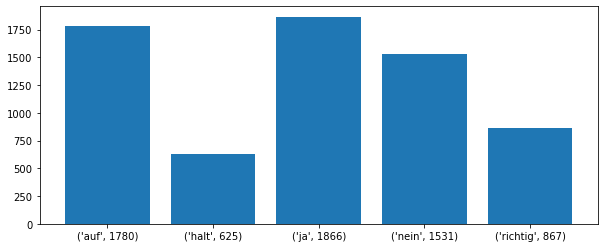

In [223]:
# label counts
wanted_words = ["auf", "halt", "ja", "nein", "richtig"]
datadir = "../../alignment_processing/de_extractions/"
counts = []
for w in wanted_words:
    counts.append(len(glob.glob(datadir + w + os.path.sep + "*.wav")))
fig, ax = plt.subplots()
ax.set_xticks(range(len(wanted_words)))
ax.set_xticklabels(zip(wanted_words, counts))
fig.patch.set_facecolor('white')
#ax.set_ylim(0,2000)
ax.bar(range(len(wanted_words)), counts);
fig.set_size_inches(10,4)

In [ ]:
row = samples["yes"].sample(n=1)
print(row.sentence.item())
row

In [87]:
wavs = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/input/*.wav")
txts = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/input/*.txt")
tgs = glob.glob("/home/mark/tinyspeech_harvard/alignment_processing/output/input/*.TextGrid")
for f in wavs + txts + tgs:
    os.remove(f)
try:
    os.rmdir("/home/mark/tinyspeech_harvard/alignment_processing/output/input/")
except FileNotFoundError:
    pass
try:
    os.remove("/home/mark/tinyspeech_harvard/alignment_processing/output/oovs_found.txt")
except FileNotFoundError:
    pass
try:
    os.remove("/home/mark/tinyspeech_harvard/alignment_processing/output/utterance_oovs.txt")
except FileNotFoundError:
    pass

In [28]:
mp3_path = COMMON_VOICE + row.path.item()
print(mp3_path)
filename_noext = os.path.basename(os.path.splitext(mp3_path)[0])

dest = f"{WORKDIR}/input/{filename_noext}.wav"

transformer = sox.Transformer()
transformer.convert(samplerate=16000)  # from 48K mp3s
#transformer.trim(start_s, end_s)
#transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
transformer.build(mp3_path, dest)

utterance = row.sentence.item()
transcription = f"{WORKDIR}/input/{filename_noext}.txt"
print(transcription)
with open(transcription, 'w') as fh:
    fh.write(utterance)

../../common_voice/en/clips/common_voice_en_18483693.mp3
../../alignment_processing//input/common_voice_en_18483693.txt


In [134]:
keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
DATASET = "../../eleven_word_dataset_de/clips/"
WORKDIR = "../../alignment_de/"

to_process = []

for kw in keywords_set:
    clips = glob.glob(DATASET + kw + os.sep + "*.wav")
    for clip in clips:
        #print(clip)
        dirname, filename = os.path.split(clip)
        txt = dirname + os.path.sep + os.path.splitext(filename)[0] + ".txt"
        to_process.append((clip, txt))
        #print(to_process)
print(len(to_process))

11686


In [139]:
mfa = "bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/"
abs_workdir = "/home/mark/tinyspeech_harvard/alignment_de/"

cmd = f"""docker run --rm \
 -v {abs_workdir}:/work/ \
 -t montreal \
 {mfa}"""
print(cmd)
shlex.split(cmd)

docker run --rm  -v /home/mark/tinyspeech_harvard/alignment_de/:/work/  -t montreal  bin/mfa_align --quiet /work/input /work/lexicon/de.dict /work/lexicon/german_prosodylab.zip /work/output/


['docker',
 'run',
 '--rm',
 '-v',
 '/home/mark/tinyspeech_harvard/alignment_de/:/work/',
 '-t',
 'montreal',
 'bin/mfa_align',
 '--quiet',
 '/work/input',
 '/work/lexicon/de.dict',
 '/work/lexicon/german_prosodylab.zip',
 '/work/output/']

In [137]:
WORKDIR

'../../alignment_de/'

In [147]:
(4 * len(to_process)) / 60 **2

12.984444444444444

In [145]:
raise ValueError("caution: modifies fs")
errors = []
for ix, (wav,txt) in enumerate(to_process):
    start = datetime.datetime.now()
    shutil.copy2(wav, WORKDIR + "/input")
    shutil.copy2(txt, WORKDIR + "/input")
    
    dirname, wav_filename = os.path.split(wav)
    file_noext = os.path.splitext(wav_filename)[0]
    print(wav_filename)
    
    tmp_wav = WORKDIR + "input/" + file_noext + ".wav"
    tmp_txt = WORKDIR + "input/" + file_noext + ".txt"
    print(tmp_wav, tmp_txt)
    
    p = subprocess.Popen(
        shlex.split(cmd),
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    sout, serr = p.communicate()
    print(sout.decode("UTF-8"), serr.decode("UTF-8"), p.returncode)
    
    if p.returncode != 0:
        errors.append([ix, sout.decode("UTF-8"), serr.decode("UTF-8") ])
        
    #os.remove()
    
    wavs = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/input/*.wav")
    txts = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/input/*.txt")
    #tgs = glob.glob("/home/mark/tinyspeech_harvard/alignment_de/output/input/*.TextGrid")
    tgs = []
    for f in wavs + txts + tgs:
        os.remove(f)
    try:
        os.rmdir("/home/mark/tinyspeech_harvard/alignment_de/output/input/")
    except FileNotFoundError:
        pass
    try:
        os.remove("/home/mark/tinyspeech_harvard/alignment_de/output/oovs_found.txt")
    except FileNotFoundError:
        pass
    try:
        os.remove("/home/mark/tinyspeech_harvard/alignment_de/output/utterance_oovs.txt")
    except FileNotFoundError:
        pass
    
    end = datetime.datetime.now()
    print(end - start)
    break

common_voice_de_18353790.wav
../../alignment_de/input/common_voice_de_18353790.wav ../../alignment_de/input/common_voice_de_18353790.txt
Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 1.0
/home/mark/montreal-forced-aligner/lib/aligner/models.py:87: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 1.0
Done with setup.
100% 2/2 [00:01<00:00,  1.41it/s]
Done! Everything took 4.184454679489136 seconds
  0
0:00:04.986833
